# ATNF Pulsar Catalog

This notebook will download the freely available ATNF pulsar database (reference: "The ATNF Pulsar Catalogue", R. N. Manchester, G. B. Hobbs, A. Teoh & M. Hobbs, Astronomical Journal, 129, 1993-2006 (2005) available at http://www.atnf.csiro.au/research/pulsar/psrcat). The resulting tar file will be extracted and then the database read in to an astropy Table object (http://www.astropy.org/).

In [1]:
#Preamble. These are some standard things I like to include in IPython Notebooks.
import astropy
from astropy.table import Table, Column, MaskedColumn
import numpy as np
import matplotlib.pyplot as plt
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]
def eAnd(*args):
    return [all(tuple) for tuple in zip(*args)]
def eOr(*args):
    return [any(tuple) for tuple in zip(*args)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
#rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
#This cell will download the ATNF database to your pwd
import urllib2
import tarfile
pulsargzfile = urllib2.urlopen('http://www.atnf.csiro.au/people/pulsar/psrcat/downloads/psrcat_pkg.tar.gz')
outputgzfile = open('psrcat_pkg.tar.gz','wb')
outputgzfile.write(pulsargzfile.read())
outputgzfile.close()
pulsargzfile.close()
pulsargz = tarfile.open('psrcat_pkg.tar.gz', 'r') 
pulsargz.extractall()

In [3]:
#Right now, the datatypes are stored either as strings or as floats 
#because, sadly, some floats are entered initially as integers in the database.
#In the future, this might be tweaked.
tests = [
    # (Type, Test)
    #(int, int),
    (float, float),
    #(datetime, lambda value: datetime.strptime(value, "%Y/%m/%d"))
]

def getType(value):
     for typ, test in tests:
         try:
             test(value)
             return typ
         except ValueError:
             continue
     # No match
     return str


In [4]:
#Main workhorse. Ultimately should be made into a function, but I prefer troubleshooting outside of def statements.
psrcatdb = 'psrcat_tar/psrcat.db'
breakstring = '@-----------------------------------------------------------------'   #Anyone know where this is from?
commentstring = '#'
versionstring = '#CATALOGUE'   #These comment strings are found at the beginning of the file.
datafile = open(psrcatdb)
psrtable = Table(masked=True)
ind = 0 #Keeps track of how many objects
masking = [] #Must keep track of the mask because the add_row method is not intelligent enough. Fix in astropy?
psrtable.add_row(None) #db file jumps right in! Better add the first row.
for line in datafile:
    dataline = line.split()   #Splits along whitespace.
    if dataline[0] == breakstring:
        psrtable.add_row(None)   #First break comes at the end of the first object and so forth.
        ind += 1                 #New object!
        psrtable.mask[ind] = masking  #This is the only way to mask a null row.
        continue
    if dataline[0] == commentstring: continue
    if dataline[0] == versionstring: continue
    if dataline[0] not in psrtable.colnames:  #Make a new column
        masking.append(True)   #Generally will be masked
        thisdatatype=getType(dataline[1])   #Note: uses function defined above
        if thisdatatype == float: thisdtstr = 'f4'  #In the future, other datatypes could be used here.
        if thisdatatype == int: thisdtstr = 'i2'
        if thisdatatype == str: thisdtstr = 'S20'
        newcolumn = MaskedColumn(name=dataline[0], dtype=thisdtstr, mask=True, length=ind+1) 
        psrtable.add_column(newcolumn)
    psrtable[dataline[0]][ind] = dataline[1] #Data entry
    psrtable[dataline[0]].mask[ind] = False #Turn off masking
psrtable.remove_row(ind) #Final breakstring comes at the end of the file

In [5]:
psrtable

PSRJ,RAJ,DECJ,P0,P1,PEPOCH,DM,S400,W50,W10,DIST_DM,DIST_DM1,SURVEY,F0,F1,F2,F3,NGLT,DIST_AMN,DIST_AMX,TYPE,ASSOC,PSRB,POSEPOCH,PMRA,PMDEC,S600,S1400,SPINDX,BINCOMP,BINARY,PB,A1,START,FINISH,CLK,EPHEM,DIST_A,TASC,EPS1,EPS2,T0,ECC,OM,OMDOT,PBDOT,PX,S100,ELONG,ELAT,PMELONG,PMELAT,S1600,RM,TAU_SC,A1DOT,S900,S800,TASC_2,PB_2,A1_2,EPS1_2,EPS2_2,SINI,M2,M2_2,MASS_Q,DM1,UNITS,KOM,KIN,S3000,S700,S5000,S2000,GAMMA,MTOT,S300,H3,H4,DM2,DM3,T0_2,T0_3,PB_3,A1_3,ECC_2,ECC_3,OM_2,OM_3,SINI_2,SINI_3,M2_3,A12DOT,OM2DOT,S6000,F4,F5,ECCDOT,DMEPOCH,FB1,FB2,S8000,S9000,STIG,OM_ASC,FB0
string160,string160,string160,float32,float32,float32,float32,float32,float32,float32,float32,float32,string160,float32,float32,float32,float32,float32,float32,float32,string160,string160,string160,float32,float32,float32,float32,float32,float32,string160,string160,float32,float32,float32,float32,string160,string160,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,string160,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0006+1834,00:06:04.8,+18:34:59,0.693748,2.097e-15,49079.5,12.0,0.2,82.0,195.0,0.7,0.68,ar4,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
J0007+7303,00:07:01.7,+73:03:07.4,--,--,54952.0,--,--,--,--,--,--,FermiBlind,3.16583,-3.612e-12,4.1e-23,5.4e-30,1.0,1.1,1.7,NRAD,GRS:2FGL_J0007.0+730,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
J0014+4746,00:14:17.75,47:46:33.4,--,--,49664.0,30.85,14.0,88.7,142.5,1.82,1.56,"gb1,gb2,gb3",0.805997,-3.6669e-16,7.3e-28,--,--,--,--,--,--,B0011+47,49664.0,19.3,-19.7,9.0,3.0,-1.3,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
J0023+0923,00:23:16.89,+09:23:24.18,0.00305,--,--,14.3,2.0,--,--,0.95,0.69,FermiAssoc,--,--,--,--,--,--,--,HE,OPT:[bvr+13],--,--,--,--,--,--,--,UL[hrm+11],BT,0.14,0.035,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
J0024-7204C,00:23:50.35311,-72:04:31.4926,--,--,51600.0,24.599,1.53,0.8,--,2.49,1.05,pksgc,173.708,1.5042e-15,--,--,--,--,--,--,"GC:47Tuc,XRS[bgh+06]",B0021-72C,--,5.2,-3.4,1.54,0.6,--,--,--,--,--,48382.8,52357.1,UTC(NIST),DE200,4.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
J0024-7204D,00:24:13.87934,-72:04:43.8405,--,--,51600.0,24.729,0.95,0.6,--,2.49,1.06,pksgc,186.652,1.195e-16,--,--,--,--,--,--,"GC:47Tuc,XRS[bgh+06]",B0021-72D,--,3.8,-2.4,0.55,--,--,--,--,--,--,48464.9,52357.1,UTC(NIST),DE200,4.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
J0024-7204E,00:24:11.1036,-72:05:20.1377,--,--,51600.0,24.23,--,0.9,--,2.49,1.03,pksgc

In [6]:
#Converting frequencies and frequency derivatives into period and period derivatives.
for obj in xrange(0, len(psrtable)):
    if psrtable['F0'].mask[obj] == False: 
        if psrtable['P0'].mask[obj] == True:
            psrtable['P0'].mask[obj] = False
            psrtable['P0'][obj] = 1.0/psrtable['F0'][obj]
        if psrtable['F1'].mask[obj] == False:
            if psrtable['P1'].mask[obj] == True:
                psrtable['P1'].mask[obj] = False
                psrtable['P1'][obj] = (-1.0*psrtable['F1'][obj])/(psrtable['F0'][obj]**2)

In [7]:
psrtable

PSRJ,RAJ,DECJ,P0,P1,PEPOCH,DM,S400,W50,W10,DIST_DM,DIST_DM1,SURVEY,F0,F1,F2,F3,NGLT,DIST_AMN,DIST_AMX,TYPE,ASSOC,PSRB,POSEPOCH,PMRA,PMDEC,S600,S1400,SPINDX,BINCOMP,BINARY,PB,A1,START,FINISH,CLK,EPHEM,DIST_A,TASC,EPS1,EPS2,T0,ECC,OM,OMDOT,PBDOT,PX,S100,ELONG,ELAT,PMELONG,PMELAT,S1600,RM,TAU_SC,A1DOT,S900,S800,TASC_2,PB_2,A1_2,EPS1_2,EPS2_2,SINI,M2,M2_2,MASS_Q,DM1,UNITS,KOM,KIN,S3000,S700,S5000,S2000,GAMMA,MTOT,S300,H3,H4,DM2,DM3,T0_2,T0_3,PB_3,A1_3,ECC_2,ECC_3,OM_2,OM_3,SINI_2,SINI_3,M2_3,A12DOT,OM2DOT,S6000,F4,F5,ECCDOT,DMEPOCH,FB1,FB2,S8000,S9000,STIG,OM_ASC,FB0
string160,string160,string160,float32,float32,float32,float32,float32,float32,float32,float32,float32,string160,float32,float32,float32,float32,float32,float32,float32,string160,string160,string160,float32,float32,float32,float32,float32,float32,string160,string160,float32,float32,float32,float32,string160,string160,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,string160,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0006+1834,00:06:04.8,+18:34:59,0.693748,2.097e-15,49079.5,12.0,0.2,82.0,195.0,0.7,0.68,ar4,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
J0007+7303,00:07:01.7,+73:03:07.4,0.315873,3.6039e-13,54952.0,--,--,--,--,--,--,FermiBlind,3.16583,-3.612e-12,4.1e-23,5.4e-30,1.0,1.1,1.7,NRAD,GRS:2FGL_J0007.0+730,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
J0014+4746,00:14:17.75,47:46:33.4,1.2407,5.64458e-16,49664.0,30.85,14.0,88.7,142.5,1.82,1.56,"gb1,gb2,gb3",0.805997,-3.6669e-16,7.3e-28,--,--,--,--,--,--,B0011+47,49664.0,19.3,-19.7,9.0,3.0,-1.3,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
J0023+0923,00:23:16.89,+09:23:24.18,0.00305,--,--,14.3,2.0,--,--,0.95,0.69,FermiAssoc,--,--,--,--,--,--,--,HE,OPT:[bvr+13],--,--,--,--,--,--,--,UL[hrm+11],BT,0.14,0.035,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
J0024-7204C,00:23:50.35311,-72:04:31.4926,0.00575678,-4.985e-20,51600.0,24.599,1.53,0.8,--,2.49,1.05,pksgc,173.708,1.5042e-15,--,--,--,--,--,--,"GC:47Tuc,XRS[bgh+06]",B0021-72C,--,5.2,-3.4,1.54,0.6,--,--,--,--,--,48382.8,52357.1,UTC(NIST),DE200,4.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
J0024-7204D,00:24:13.87934,-72:04:43.8405,0.00535757,-3.43008e-21,51600.0,24.729,0.95,0.6,--,2.49,1.06,pksgc,186.652,1.195e-16,--,--,--,--,--,--,"GC:47Tuc,XRS[bgh+06]",B0021-72D,--,3.8,-2.4,0.55,--,--,--,--,--,--,48464.9,52357.1,UTC(NIST),DE200,4.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
J0024-7204E,00:24:11.1036

In [8]:
#This adds a SkyCoord Mixin column to the table for the coordinates.
from astropy import units as u
from astropy.coordinates import SkyCoord

psrtable['coord'] = SkyCoord(psrtable['RAJ'], psrtable['DECJ'], unit=(u.hourangle, u.deg)) 

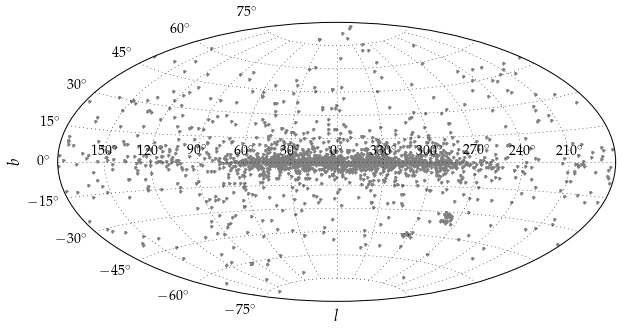

In [9]:
#Makes a scatterplot in Galactic Coordinates of all pulsars
pi = np.pi
deg2rad = pi/180.
ax = plt.figure(figsize=(10, 5))
ax = plt.subplot(111, projection='aitoff')
org=0
tick_xlabels = [r'$150^\circ$', r'$120^\circ$', r'$90^\circ$', r'$60^\circ$', r'$30^\circ$', 
                r'$0^\circ$', r'$330^\circ$', r'$300^\circ$', r'$270^\circ$', r'$240^\circ$', r'$210^\circ$']
ax.set_xticklabels(tick_xlabels, fontdict='Palatino')     # we add the scale on the x axis
#plt.set_xlabel(r'$l$')
#plt.xaxis.label.set_fontsize(16)
#plt.set_ylabel(r'$b$')
#plt.yaxis.label.set_fontsize(12)
ax.grid(True)
#plt.plot(x+np.pi/6,y+np.pi/6)
#plt.plot(x-np.pi/2,y-np.pi/2);

# Pass the coordinates in radians, since otherwise the
# aitoff projection messes up:

ax.plot(-1*psrtable['coord'].galactic.l.radian, psrtable['coord'].galactic.b.radian, '.', color='0.5')
ax.plot(2*pi-psrtable['coord'].galactic.l.radian, psrtable['coord'].galactic.b.radian, '.', color='0.5')
plt.grid(True)
plt.text(0,-100*deg2rad,r'$l$',
      ha='center', va='center', fontsize=16)
#plt.xlabel(r'$l$', fontsize=16)
plt.ylabel(r'$b$', fontsize=16)

plt.show()

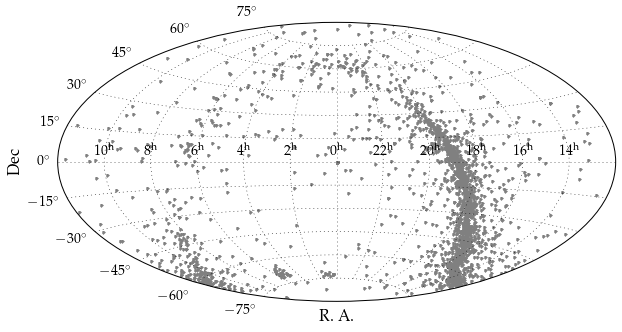

In [10]:
#Makes a scatterplot in Equatorial Coordinates centered on the First Point of Aires
ax = plt.figure(figsize=(10, 5))
ax = plt.subplot(111, projection='aitoff')
org=0
tick_xlabels = [r'$10^{\rm h}$', r'$8^{\rm h}$', r'$6^{\rm h}$', r'$4^{\rm h}$', r'$2^{\rm h}$', 
                r'$0^{\rm h}$', r'$22^{\rm h}$', r'$20^{\rm h}$', r'$18^{\rm h}$', r'$16^{\rm h}$', r'$14^{\rm h}$']
ax.set_xticklabels(tick_xlabels, fontdict='Palatino')     # we add the scale on the x axis
#plt.set_xlabel(r'$l$')
#plt.xaxis.label.set_fontsize(16)
#plt.set_ylabel(r'$b$')
#plt.yaxis.label.set_fontsize(12)
ax.grid(True)
#plt.plot(x+np.pi/6,y+np.pi/6)
#plt.plot(x-np.pi/2,y-np.pi/2);

# Pass the coordinates in radians, since otherwise the
# aitoff projection messes up:

ax.plot(-1*psrtable['coord'].ra.radian, psrtable['coord'].dec.radian, '.', color='0.5')
ax.plot(2*pi-psrtable['coord'].ra.radian, psrtable['coord'].dec.radian, '.', color='0.5')
plt.grid(True)
plt.text(0,-100*deg2rad,r'R. A.',
      ha='center', va='center', fontsize=16)
#plt.xlabel(r'$l$', fontsize=16)
plt.ylabel(r'Dec', fontsize=16)

plt.show()

/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/matplotlib/scale.py:100: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


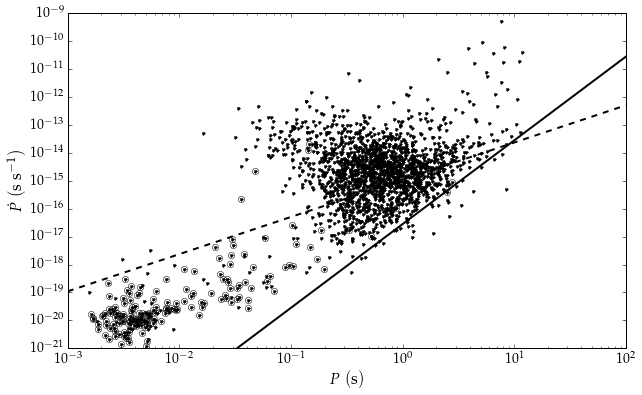

In [11]:
#This makes the famous P-Pdot diagram with the binaries circled and the spin-up and death lines indicated.
fig = plt.figure()
ax = plt.gca()
ax.plot(psrtable['P0'],psrtable['P1'], '.', c='black')
ax.set_yscale('log')
ax.set_xscale('log')
ax.plot(psrtable['P0'][psrtable['BINARY'].mask == False],psrtable['P1'][psrtable['BINARY'].mask == False], 'o',mfc='None')
ax.plot([0.0328449, 100], [1.0E-21, 2.8223E-11], color='k', linestyle='-', linewidth=2)
ax.plot([1.E-3, 1.E2], [1.1E-19, 5.1E-13], color='k', linestyle='--', linewidth=2)
plt.xlabel(r'$P\ {\rm(s)}$', fontsize=16)
plt.ylabel(r'$\dot{P}\ {\rm(s\ s^{-1})}$', fontsize=16)

# Binary millisecond pulsar populations

We now include a means to plot the PDF of the companion masses to binary pulsars. The claim has been made that there are two populations of short-period binary millisecond pulsars (Roberts et al. 2011) that have a rough boundary at companion masses that are approximately one tenth of the mass of the Sun. Let's see if we can find these populations. Here we make the assumption that the pulsar mass is $m_p = 1.4\ {\rm M_\odot}$, the inclination angle is randomly distributed with a pdf per angle 
$$\frac{dp}{di} = \sin i,$$ 
and through a measurement of the projected semi-major axis ($a_p$) and the orbital period of the binary ($P_b$), that the binary mass function is
$$f = 0.001074\ {\rm M_\odot} \frac{\left(a_p \sin i\right)^3}{P_b^2} = \frac{\left(m_c \sin i\right)^3}{\left(m_c+m_p\right)^2}.$$

In [12]:
from scipy.interpolate import interp1d
from scipy.special import cbrt

def plot_companion_masses(psrtable, m=1.4, plot=True):
    sines = np.linspace(0, 1., num=1000.)
    fobs = 0.001074*(psrtable['A1']**3)/(psrtable['PB']**2) #from above
    fobs = fobs.compressed() #eliminates the masked values
    fobs = np.float64(fobs)
    #m = 1.4 #for now. Could also assume a prior probability density of pulsar masses. 
    mc = np.ndarray(shape=(len(sines),len(fobs)), dtype=float)
    for ind,sin in enumerate(sines):
        s = sin**3 #Solving the cubic
        mc[ind,:] = -1.*cbrt(-2.*fobs**3*s**6-18.*fobs**2*m*s**7+3*np.sqrt(3.)*\
                np.sqrt(4.*fobs**3.*m**3*s**15.+27.*fobs**2*m**4*s**16)-27*fobs*m**2*s**8)/\
                (3*cbrt(2.)*s**3)+(cbrt(2.)*(-729.*fobs**2*s**4-4374.*fobs*m*s**5))/\
                (2187.*s**3*cbrt(-2.*fobs**3*s**6-18*fobs**2*m*s**7+3.*np.sqrt(3.)*\
                np.sqrt(4.*fobs**3*m**3*s**15+27*fobs**2*m**4*s**16)-27*fobs*m**2*s**8))+fobs/(3*s)
    mmc = 10.**(np.linspace(-3, 1, num=1000, endpoint=True)) #Logarithmic distribution
    probdens = np.zeros(len(mmc))
    for ind,stuff in enumerate(fobs):
        thems = mc[:,ind]
        logmprob = (sines**3)*(thems+3*m)/(3*(thems+m)*np.sqrt(1.0-sines**2)) #transformed into a PDF of logm
        flow = interp1d(thems[1:], logmprob[1:])
        probdens[np.logical_and(mmc > thems[-2],mmc < thems[1])] += flow(mmc[np.logical_and(mmc > thems[-2],mmc < thems[1])])
    if plot is True:
        ax = plt.gca()    
        ax.plot(mmc,probdens, linestyle='-', color='k',)
        ax.set_xscale('log')
        plt.xlabel(r'$m_c\ {\rm(M_\odot)}$', fontsize=16)
        plt.ylabel('PDF (arbitrarily scaled)', fontsize=16)
        silent=plt.xlim(1e-3,1e1)
    return probdens

First, let's look at the PDF  for all binary pulsars with measured periods and projected semi-major axes which was calculated above to be
$$\frac{dp}{d\log m_c} = -m_c\frac{di}{dm_c}\frac{dp}{di} = \frac{\sin^2 i \left(3m_p+m_c\right)}{3\left(m_c+m_p\right)\cos i} \sin i. $$
Note that this means that the functional form of the probability density function diverges as $i \rightarrow 90^\circ$ as the PDF conserves the integral and is unaffected by removable discontinuities. Nevertheless, plotting the PDF can give a sense for what size of companion mass is most common and which is least common.

/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in divide
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in multiply
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


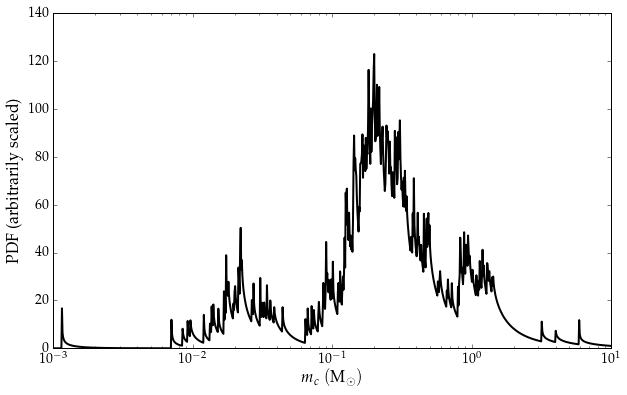

In [13]:
prob = plot_companion_masses(psrtable, m=1.4)

Now we'll look at the same plot but only considering those binaries with periods less than 1 day.

/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in divide
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide


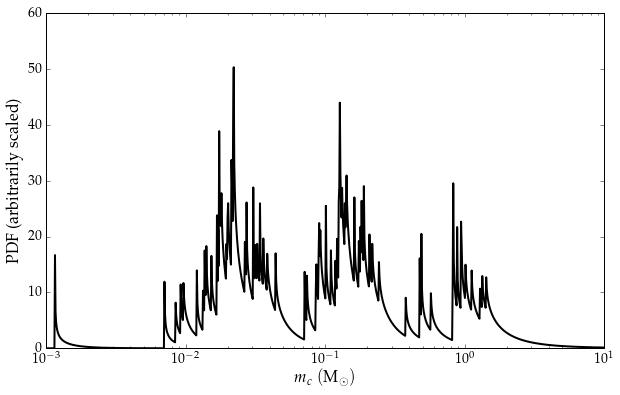

In [14]:
shortper = psrtable[psrtable['PB'] < 1.]
prob = plot_companion_masses(shortper, m=1.4)

Three populations? But wait! We should remove all the objects which are not millisecond pulsars, shouldn't we? Some young pulsars are born in binaries and are likely to have higher mass companions. Let's see if we make this additional cut whether the two populations will be more clearly demarcated.

/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in divide
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide


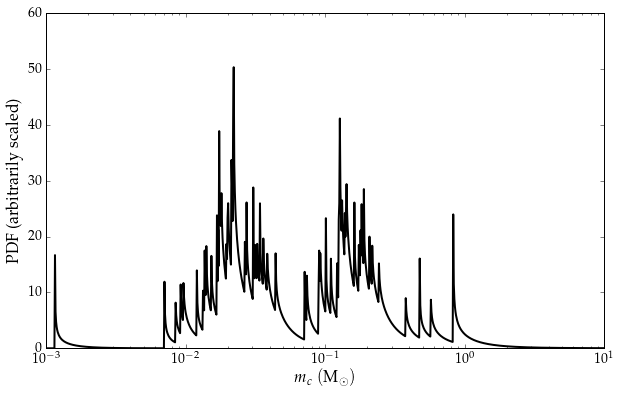

In [15]:
millisec = psrtable[np.logical_and(psrtable['P0'] < 0.02, psrtable['PB'] < 1.)]
prob = plot_companion_masses(millisec, m=1.4)

There is clearly a bifurcation of the two populations with a break around $m_c \sim 5 \times 10^{-2}\ {\rm M_\odot}$.

As for what's left, we can show the PDF for normal pulsars in binaries:

/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in divide
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide


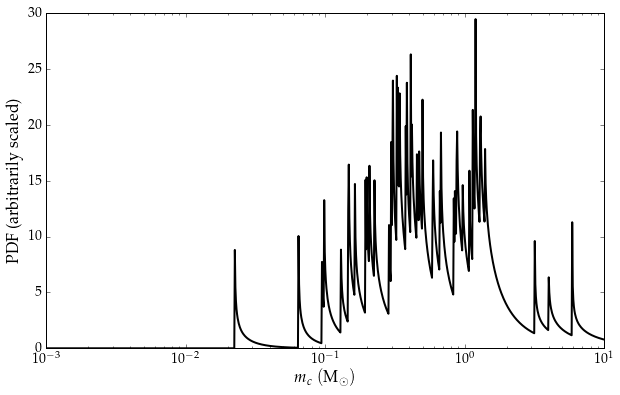

In [16]:
longyoung = psrtable[np.logical_and(psrtable['P0'] > 0.02, psrtable['PB'] > 1.)]
prob = plot_companion_masses(longyoung, m=1.4)

As well as millisecond pulsars in wide binaries:

/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in divide
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in multiply
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


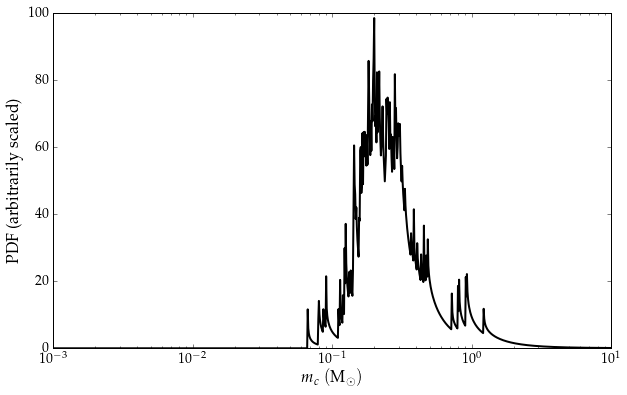

In [17]:
longold = psrtable[np.logical_and(psrtable['P0'] < 0.02, psrtable['PB'] > 1.)]
prob = plot_companion_masses(longold, m=1.4)

This all assumed a single mass for the pulsar. Of course, that's likely not fair in spite of theories from considerations of double neutron star systems that the PDF of birth masses for neutron stars was strongly peaked around $\sim 1.35\ {\rm M_\odot}$. In more modern treatments, for example  Özel et al. (2012) http://arxiv.org/pdf/1201.1006v2.pdf, the empirical PDFs are calculated. In Özel et al. (2012), the mass PDF for recycled pulsars is a Gaussian with a mean $M_p = 1.48\ {\rm M_\odot}$ and spread $\sigma = 0.22\ {\rm M_\odot}$ while the mass PDF for fast/high-mass binary accreting pulsars is $M_p = 1.28\ {\rm M_\odot}$ and spread $\sigma = 0.28\ {\rm M_\odot}$. Note that using these PDFs is somewhat circular reasoning and it really amounts to taking something like a Gaussian smoothing kernel over the distribution. A more careful analysis would allow for the various mass-uncertainties to be incorporated for each object in something of a bootstrapping fashion where the post-Keplerian determined masses arrived in the distribution more-or-less as delta functions while the uncertainties in the masses for other binaries were constructed from more carefully considered likelihood functions.

/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in divide
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in multiply
/Users/joshuapaultan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


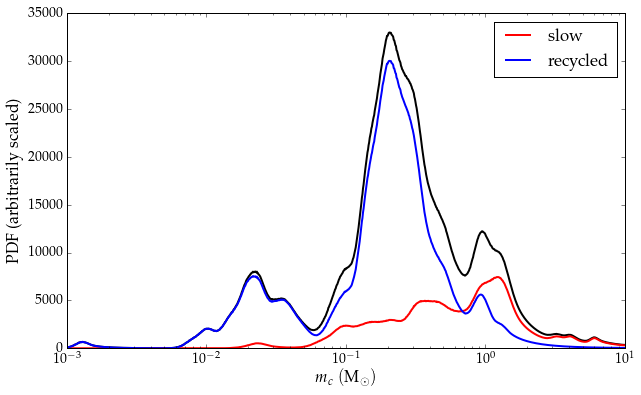

In [18]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

#Here we consider what the PDF for companion masses would look like assuming the PDF for pulsar masses
#weighted by the above functions sampling 500 different pulsar masses from 0.6 to 2.0 solar masses in size.
mmc = 10.**(np.linspace(-3, 1, num=1000, endpoint=True))
mparray = np.linspace(0.6, 2.0, num=500, endpoint=True)
probold = np.zeros(len(mmc))
probyoung = np.zeros(len(mmc))
probspmsp = np.zeros(len(mmc))
#This for loop takes quite a while!
for mass in mparray: 
    probold += plot_companion_masses(longold, m=mass, plot=False)*gaussian(mass,1.48,0.22)
    probyoung += plot_companion_masses(psrtable[psrtable['P0'] > 0.02], m=mass, plot=False)*gaussian(mass,1.28,0.28)
    probspmsp += plot_companion_masses(millisec, m=mass, plot=False)*gaussian(mass,1.48,0.22)
probdens = probold+probyoung+probspmsp
    
ax = plt.gca()    
ax.plot(mmc,probdens, linestyle='-', color='k',)
ax.plot(mmc,probyoung, linestyle='-', color='r',label='slow')
ax.plot(mmc,probold+probspmsp, linestyle='-', color='b',label='recycled')
ax.set_xscale('log')
plt.xlabel(r'$m_c\ {\rm(M_\odot)}$', fontsize=16)
plt.ylabel('PDF (arbitrarily scaled)', fontsize=16)
silent=plt.xlim(1e-3,1e1)
plt.legend()

The PDF for the masses of companions to short-period binary millisecond pulsars using the empirical PDFs for the masses of the recycled pulsars themselves is...

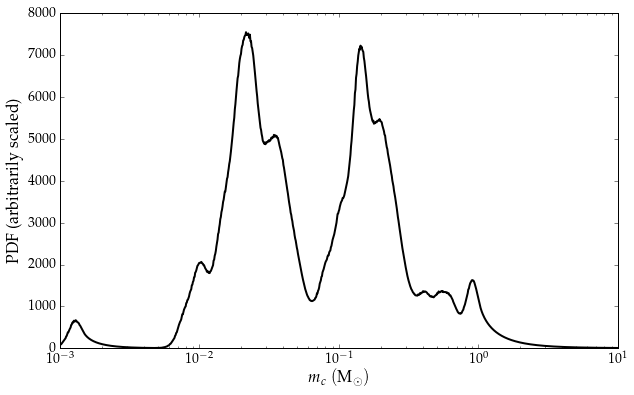

In [19]:
ax = plt.gca()    
ax.plot(mmc,probspmsp, linestyle='-', color='k',)
ax.set_xscale('log')
plt.xlabel(r'$m_c\ {\rm(M_\odot)}$', fontsize=16)
plt.ylabel('PDF (arbitrarily scaled)', fontsize=16)
silent=plt.xlim(1e-3,1e1)